# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import dotenv

dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.getenv("PROJECT_CONNECTION_STRING"),
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [5]:
# from azure.ai.projects.models import BingGroundingTool

# import datetime
# current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# bing_connection = project_client.connections.get(
#     connection_name=os.getenv("BING_CONNECTION_NAME")
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="bingSearchAgent2",
#     description="Agent to perform web searches using Bing.",
#     model="gpt-4o",
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions=f"""
#     You are a helpful research assistant.
    
#     Today's date is {current_date}.
    
#     Use your available tools (like Bing web search) to find information relevant to the user's query.
#     When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
#     Provide a comprehensive answer based on the search results.
#     """.strip()
# )

If you already have an Azure AI Agent, run this cell to update it's instructions with today's date.

In [6]:
import datetime

current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-05-26.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


**OpenAI Agents**

In [ ]:
from agents import (
    Agent,
    ModelSettings
)

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)

peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [8]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

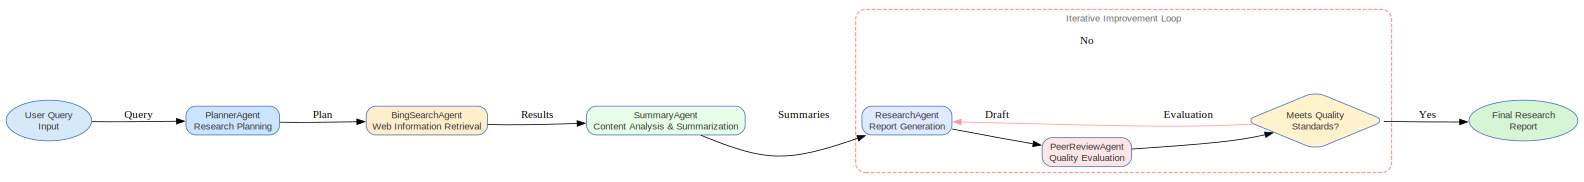

In [9]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [30]:
user_query="What big industries will AI have the most affected on?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [31]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [32]:
plan.final_output.research_tasks[0].search_queries

['AI impact on healthcare industry',
 'How is artificial intelligence used in medical diagnostics?',
 'AI-driven healthcare innovations 2024',
 'Case studies of AI in hospitals',
 'AI in drug discovery and development']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [33]:
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.create_thread()
            message = project_client.agents.create_message(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.create_and_process_run(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.delete_thread(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred processing query 'AI impact on healthcare industry': ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Subtopics: 100%|██████████| 5/5 [03:53<00:00, 46.62s/it]32<00:46, 15.45s/it]


In [34]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 25

Actually total search queries: 25



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [35]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=summary_prompt
            )
            subtopic_summary = summary_response.final_output # Adjust based on actual response structure
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics:   0%|          | 0/5 [00:00<?, ?it/s]

Summarizing subtopics: 100%|██████████| 5/5 [00:55<00:00, 11.15s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [36]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [37]:
from agents import HandoffCallItem
import json

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [38]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# The Transformative Impact of Artificial Intelligence Across Major Industries: A Comprehensive Analysis

## Introduction

Artificial intelligence (AI) has emerged as a defining force in the evolution of modern industry, catalyzing profound changes across sectors as diverse as healthcare, finance, manufacturing, retail, and transportation. The rapid maturation of AI technologies—encompassing machine learning, natural language processing, computer vision, and robotics—has enabled organizations to reimagine traditional processes, unlock new business models, and address challenges previously deemed intractable. This report provides an in-depth analysis of the industries most significantly affected by AI, exploring the mechanisms of transformation, the extent of disruption, and the broader implications for stakeholders. Drawing on recent data, case studies, and expert perspectives, the report also examines emerging trends, future projections, and the opportunities and challenges that accompany the widespread adoption of AI.

To structure this analysis, the report is organized into five thematic sections, each focusing on a major industry: Healthcare, Financial Services and Banking, Manufacturing and Supply Chain, Retail and E-commerce, and Transportation and Automotive. For each sector, the report details the specific ways AI is reshaping operations, highlights illustrative case studies, and synthesizes recent developments with forward-looking insights. The discussion is further enriched by comparative data visualizations and a critical assessment of cross-industry trends, culminating in a holistic understanding of AI’s transformative power in the contemporary economy.

## 1. Healthcare Industry

### 1.1. AI-Driven Diagnostics and Early Disease Detection

The healthcare sector stands at the forefront of AI-driven transformation, with applications that span diagnostics, treatment, operational efficiency, and research. One of the most prominent impacts of AI is in medical diagnostics, where advanced algorithms analyze complex imaging data—such as X-rays, CT scans, MRIs, and ultrasounds—with remarkable speed and accuracy. These systems often outperform traditional diagnostic methods, reducing human error and enabling earlier detection of diseases. For instance, the collaboration between Moorfields Eye Hospital and DeepMind resulted in an AI system capable of diagnosing over 50 eye diseases from retinal scans, achieving accuracy on par with leading ophthalmologists [1][6][8][15]. Similarly, the Mayo Clinic’s integration of AI tools for lung nodule detection in CT scans has expedited diagnostics and improved precision [4][13].

Beyond imaging, AI’s capacity to identify subtle patterns in large-scale medical data has revolutionized early disease detection for conditions such as cancer, diabetes, and cardiovascular diseases. Real-time AI systems, like those implemented at Johns Hopkins for sepsis detection, continuously monitor patient data, alerting clinicians to potential cases before critical symptoms manifest. This proactive approach has been linked to improved patient survival rates and reduced complications [13][14].

### 1.2. Predictive Analytics and Personalized Medicine

Predictive analytics, underpinned by machine learning, leverages historical and real-time patient data to assess risk factors and forecast outcomes. This enables healthcare providers to intervene earlier, personalize treatment plans, and manage population health more effectively. AI-powered natural language processing (NLP) further augments clinical decision-making by extracting actionable insights from unstructured data sources, such as electronic health records and medical literature [3][7]. These capabilities support more informed diagnoses and treatment planning, contributing to improved patient outcomes.

Personalized medicine, a rapidly advancing field, benefits immensely from AI-driven biomarker discovery and patient stratification. By analyzing genetic, clinical, and lifestyle data, AI enables the development of highly tailored treatment regimens, maximizing therapeutic efficacy while minimizing adverse effects. This individualized approach is increasingly central to oncology, rare disease management, and chronic condition care [2][10][11].

### 1.3. Operational Efficiency and Robotic Surgery

AI’s influence extends into the operational fabric of healthcare institutions. Hospitals such as the Cleveland Clinic utilize AI to streamline administrative tasks, including patient scheduling and resource allocation, resulting in reduced wait times and optimized resource utilization [4][7]. In surgical settings, AI-powered robotic systems, exemplified by those at Mount Sinai Health System, assist surgeons in performing minimally invasive procedures with enhanced precision and real-time analytics. These innovations contribute to fewer complications, shorter recovery periods, and overall improvements in surgical outcomes [13][14].

### 1.4. AI in Drug Discovery and Development

The pharmaceutical industry is undergoing a paradigm shift, with AI revolutionizing drug discovery and development. AI algorithms can rapidly analyze vast chemical libraries to identify promising molecules, predict drug-target interactions, and optimize the design and recruitment for clinical trials. This approach dramatically reduces the time and cost required to bring new therapies to market. AI also supports drug repurposing—finding new therapeutic uses for existing medications—thereby maximizing the value of prior research investments [2][9][10][11]. The industry’s AI spending is projected to reach $3 billion by 2025, reflecting the growing recognition of AI’s strategic importance [9].

### 1.5. Challenges and Opportunities

Despite these advancements, the integration of AI in healthcare is not without challenges. Ensuring the reliability, transparency, and ethical use of AI systems remains paramount, particularly as these technologies increasingly influence critical clinical decisions. Concerns around data privacy, algorithmic bias, and regulatory compliance persist, necessitating robust governance frameworks. Nevertheless, the collective evidence from hospital case studies, industry trends, and technological innovations underscores AI’s transformative potential to enhance diagnostic accuracy, patient care, operational efficiency, and the pace of medical research [1][4][15].

### 1.6. Future Projections

Looking ahead, AI is poised to play an even more central role in healthcare, with advancements in explainable AI, federated learning, and multi-modal data integration expected to further improve outcomes. The convergence of AI with genomics, wearable technologies, and telemedicine will likely drive the next wave of innovation, expanding access to high-quality care and enabling more proactive health management [1][4][13][15].

## 2. Financial Services and Banking

### 2.1. AI-Enabled Fraud Detection and Security

The financial services and banking sector has embraced AI as a catalyst for operational efficiency, risk mitigation, and enhanced customer experience. Among the most impactful applications is real-time fraud detection. AI-driven algorithms analyze vast volumes of transactional data, identifying anomalous patterns and flagging potentially fraudulent activities with high accuracy. These systems employ adaptive machine learning models that evolve alongside emerging fraud tactics, enabling proactive prevention and significantly reducing financial losses [1][2][3][4].

### 2.2. Personalized Customer Experience

AI-powered chatbots and virtual assistants have become central to banking operations, providing 24/7 personalized support, handling routine inquiries, and facilitating transactions without human intervention. Generative AI further elevates this experience by delivering tailored financial advice and product recommendations, leveraging customer data to anticipate needs and suggest optimal solutions. This personalization not only increases customer satisfaction but also drives cross-selling and up-selling opportunities for financial institutions [1][2][3].

### 2.3. Predictive Risk Management and Regulatory Compliance

AI has revolutionized risk management through predictive analytics. By analyzing a broader set of data points—including non-traditional indicators—AI models improve the accuracy of credit risk assessments, support dynamic portfolio optimization, and enable more informed decision-making. These advancements reduce default rates and enhance overall financial stability. AI also automates regulatory compliance processes, monitoring transactions for anti-money laundering (AML) and know-your-customer (KYC) requirements, ensuring adherence to legal standards and reducing the burden of manual compliance checks [2][4][6].

### 2.4. Process Automation and Operational Efficiency

AI-driven process automation streamlines routine and repetitive tasks such as loan approvals, document verification, and compliance reporting. Robotic process automation (RPA) combined with AI accelerates turnaround times, reduces operational costs, and minimizes human error. This allows financial institutions to reallocate human resources to higher-value activities and strategic initiatives, fostering innovation and agility [3][4].

### 2.5. Financial Inclusion and Adaptive Credit Scoring

A particularly transformative impact of AI is observed in financial inclusion. Adaptive credit scoring models enable banks to assess the creditworthiness of individuals with limited or no traditional credit history, thus extending banking and micro-financing services to underserved and unbanked populations. These models analyze alternative data sources—such as mobile phone usage, utility payments, and social media activity—to construct more holistic risk profiles, fostering greater access to financial products and services [5].

### 2.6. Challenges and Opportunities

The adoption of AI in financial services is not without challenges. Ensuring data privacy, managing algorithmic bias, and maintaining regulatory compliance are ongoing concerns as AI adoption accelerates. The complexity of financial data and the potential for unintended consequences from automated decision-making necessitate robust oversight and transparent governance. Nonetheless, the benefits—ranging from operational efficiency to expanded financial inclusion—are substantial, positioning AI as a cornerstone of the future financial ecosystem [6].

### 2.7. Future Projections

The continued evolution of AI in financial services will likely focus on refining existing applications, expanding their reach, and addressing ethical and governance considerations. The integration of AI with blockchain, quantum computing, and advanced analytics is expected to unlock new capabilities, further enhancing security, efficiency, and customer-centricity [1][6].

## 3. Manufacturing and Supply Chain

### 3.1. Predictive Maintenance and Quality Control

The integration of AI into manufacturing and supply chain management is ushering in an era of operational excellence, characterized by heightened efficiency, reduced costs, and enhanced decision-making. Predictive maintenance, enabled by AI, continuously monitors machinery through advanced sensors and analyzes operational data to predict equipment failures before they occur. This proactive approach minimizes unplanned downtime, extends asset life, and significantly reduces maintenance costs, becoming a cornerstone for uninterrupted production [1][2][3][9].

AI-powered vision systems, leveraging deep learning and computer vision, have transformed quality control. These systems inspect products in real time, detecting defects and inconsistencies with far greater speed and accuracy than manual inspection. The result is consistent product quality, reduced waste, and rapid feedback loops for process improvement [2][4][5].

### 3.2. Supply Chain Optimization and Demand Forecasting

AI-driven demand forecasting models analyze vast datasets—including historical sales, market trends, and external variables—to predict demand with unprecedented accuracy. Studies indicate that AI can reduce forecasting errors by up to 50%, directly translating to fewer stockouts, lower inventory holding costs, and improved customer satisfaction [1][5][10]. In logistics, AI optimizes transportation routes and warehouse operations, dynamically adjusting to disruptions and minimizing delays and costs. Real-time resource allocation and logistics adjustments, powered by AI, enhance operational agility and resilience in the face of supply chain volatility [4][7][8].

### 3.3. Smart Factories and Industry 4.0

The concept of the smart factory is realized through the integration of AI with Internet of Things (IoT) devices and robotics. This convergence enables real-time monitoring of production processes, automated order picking, and warehouse management, all orchestrated by AI-driven analytics. The result is a highly automated, data-driven environment where decisions are made instantaneously based on live operational data, further accelerating production cycles and reducing manual errors [2][6][7].

### 3.4. Sustainability and Back-Office Automation

AI contributes to sustainability initiatives by optimizing routes and reducing waste through precise planning and resource utilization. Automation of back-office operations such as document processing and procurement not only improves speed and accuracy but also frees up human resources for more strategic activities [8][9].

### 3.5. Challenges and Opportunities

The rapid adoption of AI in manufacturing and supply chain management is driven by clear strategic benefits: enhanced efficiency, cost savings, improved product quality, and increased supply chain resilience. However, challenges remain, including the need for workforce reskilling, data integration across legacy systems, and ensuring cybersecurity in increasingly connected environments. Addressing these challenges is critical to realizing the full potential of AI-driven transformation [1][7][10].

### 3.6. Future Projections

Investment in AI technologies is expected to continue growing, solidifying AI’s role as a critical enabler of competitive advantage in the manufacturing sector. The ongoing evolution toward Industry 4.0, characterized by interconnected, intelligent systems, is fundamentally reshaping how goods are produced, moved, and delivered, with AI at the core of this transformation [1][2][6].

## 4. Retail and E-commerce

### 4.1. Personalized Shopping Experiences and Customer Engagement

AI is reshaping the landscape of retail and e-commerce, driving a paradigm shift in how businesses engage with customers, manage operations, and sustain competitive advantage. At the forefront of this transformation is the deployment of AI-powered personalized shopping experiences. Retailers leverage sophisticated recommendation systems, sentiment analysis, and AI-driven chatbots to predict individual customer preferences, suggest tailored products, and foster deeper engagement. Tools such as visual search and virtual fitting rooms further enhance personalization, allowing customers to find items that precisely match their tastes and requirements [1][8][9][11].

### 4.2. Inventory Management and Supply Chain Efficiency

Inventory management, a traditionally complex and resource-intensive aspect of retail, has been revolutionized by AI through predictive analytics, machine learning, and real-time data processing. AI systems excel at demand forecasting, analyzing historical sales data, market trends, and external variables to accurately predict future demand. This enables retailers to maintain optimal stock levels, effectively mitigating the risks of overstocking or stockouts. Real-time inventory monitoring across multiple locations ensures swift decision-making and efficient replenishment, while automation of routine tasks reduces manual labor and frees up human resources for more strategic functions [4][5][6][7].

### 4.3. AI-Powered Chatbots and Virtual Assistants

AI-powered chatbots and virtual assistants are increasingly central to modern e-commerce strategies. These technologies provide round-the-clock customer support, handle multiple interactions simultaneously, and guide shoppers through their purchasing journey with personalized recommendations. By automating repetitive tasks, chatbots reduce operational costs and improve efficiency, allowing businesses to focus on higher-value strategic initiatives. The integration of voice commerce—enabled by advances in voice recognition and natural language processing—has introduced hands-free shopping experiences via platforms like Amazon Alexa, further streamlining the customer journey [1][3][10][12].

### 4.4. Marketing, Customer Insights, and Immersive Experiences

AI enables highly targeted marketing campaigns and personalized offers by analyzing vast amounts of customer data, including purchase history and behavioral patterns. This deepens customer relationships and increases loyalty. AI tools provide actionable customer insights, allowing retailers to refine product offerings and marketing strategies. Immersive technologies such as virtual try-ons and augmented reality shopping, powered by AI, create engaging and interactive shopping environments that further differentiate retailers in a crowded marketplace [8][13][15][16].

### 4.5. Challenges and Opportunities

While AI offers substantial benefits in retail and e-commerce, challenges persist. These include ensuring data privacy, managing algorithmic bias in personalization, and integrating AI with legacy systems. The rapid pace of technological change also necessitates continuous workforce training and adaptation. Nonetheless, AI’s ability to personalize customer interactions, optimize backend operations, and automate routine tasks is fundamentally reshaping how retailers connect with and serve their customers [1][5][16].

### 4.6. Future Projections

As AI technologies continue to evolve—particularly with advancements in generative AI and immersive experiences—their role in retail will only deepen. The future will likely see even more intuitive and adaptive chatbots, seamless integration of online and offline experiences, and further automation of supply chain and inventory management processes [1][8][19].

## 5. Transportation and Automotive

### 5.1. Autonomous Vehicles and Advanced Driver Assistance

AI is at the forefront of a sweeping transformation in the transportation and automotive industries, serving as the engine behind innovations that enhance efficiency, safety, sustainability, and customer experience. AI, particularly through machine learning algorithms, acts as the “brain” of autonomous vehicles, processing vast streams of data from sensors such as cameras, radar, and LiDAR. These systems enable real-time object recognition, movement prediction, and decision-making, which are critical for safe and efficient navigation. The industry is witnessing rapid progress toward Level 4 autonomy, where vehicles can operate without human intervention in most environments. This advancement is particularly impactful in logistics, where unmanned vehicles and drones are optimizing cargo transport and last-mile deliveries, driving down operational costs and improving delivery reliability [1][5][7][8][10].

AI also powers Advanced Driver Assistance Systems (ADAS), including features like lane-keeping, adaptive cruise control, and emergency braking, which collectively reduce human error—the leading cause of road accidents. By 2030, it is anticipated that the majority of vehicles will be network-connected, facilitating real-time data exchange that enhances navigation, safety, and overall mobility [5][9][13].

### 5.2. Smart Traffic Management and Urban Mobility

AI is revolutionizing traffic management by leveraging real-time data analytics to optimize traffic flow, reduce congestion, and minimize emissions. Adaptive traffic control systems dynamically adjust signal timings based on live sensor and camera data, while predictive analytics forecast traffic patterns to proactively prevent bottlenecks. These systems are integral to the development of intelligent transportation networks within smart cities, where AI-driven digital twins and infrastructure monitoring enhance maintenance and operational efficiency [11][12][14][15].

### 5.3. Logistics Optimization and Fleet Management

In logistics, AI is transforming traditional supply chains into agile, data-driven systems. Route optimization algorithms utilize real-time traffic and weather data to determine the most efficient delivery paths, reducing transit times and fuel consumption. Predictive analytics forecast demand, maintenance needs, and potential disruptions, enabling proactive decision-making and minimizing downtime. AI-powered transportation management systems automate scheduling, inventory tracking, and problem resolution, streamlining operations and reducing manual intervention. Early adopters of these technologies have reported up to 15% savings in logistics costs due to improved planning and reduced inefficiencies [3][7][16][17].

### 5.4. Automotive Manufacturing Innovation

AI’s impact extends deeply into automotive manufacturing, driving significant improvements in efficiency, quality, and sustainability. Predictive maintenance systems, powered by AI, monitor equipment health and anticipate failures, reducing unexpected downtime and operational costs by up to 20%. Advanced computer vision systems perform defect detection and visual inspections with greater precision than traditional methods, elevating product quality and consistency. The adoption of collaborative robots (cobots) equipped with AI capabilities allows for greater precision and adaptability on assembly lines, facilitating safer and more efficient human-machine collaboration. Generative design tools, leveraging AI, create optimized vehicle components that are lighter and more efficient, contributing to overall vehicle performance and sustainability [4][6][18][19].

### 5.5. Challenges and Opportunities

Despite these advancements, challenges persist. Autonomous systems must contend with unpredictable human behavior, evolving regulatory landscapes, and the imperative for robust data security. The complexity of integrating AI with legacy infrastructure and ensuring interoperability across diverse platforms also poses significant hurdles. Nonetheless, the convergence of autonomous vehicles, smart infrastructure, and intelligent logistics is not only reducing operational costs and environmental impact but also redefining mobility and manufacturing paradigms [5][7][13].

### 5.6. Future Projections

The future of transportation and automotive industries will be characterized by smarter, greener, and safer systems. The continued evolution of AI-driven vehicles, the expansion of smart city infrastructure, and the integration of AI with emerging technologies such as 5G and edge computing will further accelerate innovation and transformation across the sector [1][5][10][15].

## 6. Comparative Analysis and Cross-Industry Trends

### 6.1. Impact Assessment Matrix

The following table provides a comparative overview of AI’s impact across the five major industries discussed:

| Industry                   | Key AI Applications                | Impact Highlights                              | Projected Growth/Trends         |
|----------------------------|------------------------------------|------------------------------------------------|---------------------------------|
| Healthcare                 | Diagnostics, drug discovery, NLP   | Enhanced accuracy, early detection, efficiency | Precision medicine, explainable AI |
| Financial Services/Banking | Fraud detection, chatbots, risk    | Security, personalization, inclusion           | GenAI, blockchain integration   |
| Manufacturing/Supply Chain | Predictive maintenance, forecasting| Efficiency, quality, resilience                | Industry 4.0, smart factories   |
| Retail/E-commerce          | Personalization, inventory, chatbots| CX, sales, operational efficiency              | Generative AI, immersive CX     |
| Transportation/Automotive  | Autonomy, traffic, logistics, robotics| Safety, sustainability, cost savings           | Level 4 autonomy, smart cities  |

### 6.2. Cross-Industry Opportunities and Challenges

Across all sectors, AI is driving operational efficiency, enabling new business models, and enhancing customer experience. The convergence of AI with other emerging technologies—such as IoT, blockchain, and edge computing—is amplifying these effects. However, common challenges persist, including data privacy, algorithmic bias, workforce adaptation, and regulatory compliance. Addressing these issues will require coordinated efforts among industry stakeholders, policymakers, and technologists.

## Conclusion

Artificial intelligence is fundamentally reshaping the competitive landscape of major industries, catalyzing innovation and disruption at an unprecedented pace. The healthcare, financial services, manufacturing, retail, and transportation sectors exemplify the breadth and depth of AI’s transformative power. While the benefits are substantial—ranging from improved outcomes and efficiency to expanded access and personalization—the challenges are equally significant. Navigating the ethical, regulatory, and operational complexities of AI adoption will be critical to realizing its full potential. As AI technologies continue to evolve, their influence will only deepen, presenting both opportunities and responsibilities for organizations and society at large.

## References

[1] AI in Healthcare: 10 Transformative Trends to Watch in 2024, https://www.analyticsinsight.net/artificial-intelligence/ai-in-healthcare-10-transformative-trends-to-watch-in-2024
[2] Nature and AI in drug discovery: a solution to high costs, https://www.weforum.org/stories/2025/01/turning-to-nature-and-ai-in-drug-discovery/
[3] Future Use of AI in Diagnostic Medicine: 2-Wave Cross ... - ScienceDirect, https://www.sciencedirect.com/org/science/article/pii/S1438887125002900
[4] How Digital & AI Will Reshape Health Care in 2025 | BCG, https://www.bcg.com/publications/2025/digital-ai-solutions-reshape-health-care-2025
[5] AI in Banking: 2025 Trends | Devoteam, https://www.devoteam.com/en-se/expert-view/ai-in-banking-2025-trends/
[6] AI in Banking in 2025: 5 Key Uses & Tools Explained, https://www.edstellar.com/blog/ai-in-banking
[7] AI in manufacturing: Transforming engineering, production and supply chains, https://blogs.sw.siemens.com/tecnomatix/ai-in-manufacturing-transforming-engineering-production-and-supply-chains/
[8] AI in Retail: Optimizing Inventory and Supply Chain Efficiency, https://wgaadvisors.com/2025/03/20/ai-in-retail-optimizing-inventory-and-supply-chain-efficiency/
[9] AI in Pharma and Biotech: Market Trends 2025 and Beyond, https://www.coherentsolutions.com/insights/artificial-intelligence-in-pharmaceuticals-and-biotechnology-current-trends-and-innovations
[10] What’s next in AI drug discovery in 2025? – Intelligent Health.tech, https://www.intelligenthealth.tech/2025/03/18/whats-next-in-ai-drug-discovery-in-2025/
[11] AI in Drug Discovery: Revolutionizing the Pharmaceutical Industry in 2025, https://www.linkedin.com/pulse/ai-drug-discovery-revolutionizing-pharmaceutical-2025-carrasquillo-oalwe
[12] AI in Supply Chain: A Strategic Guide [2025-2030] | StartUs Insights, https://www.startus-insights.com/innovators-guide/ai-in-supply-chain/
[13] Artificial Intelligence in Healthcare: 2025 Guide - ZEGOCLOUD, https://www.zegocloud.com/blog/artificial-intelligence-in-healthcare
[14] 7 Inspiring Ways AI Is Revolutionizing Medical Diagnostics in 2025, https://aibriefnow.com/medical-diagnostic-ai-is-revolutionizing-in-2025/
[15] Top 10 AI Innovations Revolutionizing Healthcare In 2024, https://bostoninstituteofanalytics.org/blog/top-10-ai-innovations-transforming-the-healthcare-industry-in-2024/
[16] AI in Retail and E-Commerce: 30 Examples to Know, https://builtin.com/artificial-intelligence/ai-retail-ecommerce-tech
[17] AI in Logistics and Transportation: A Guide - emitrr.com, https://emitrr.com/blog/ai-in-logistics-and-transportation/
[18] AI-Led Transformation in Automotive Manufacturing, https://researchnxt.com/guide-to-ai/ai-led-transformation-in-automotive-manufacturing/
[19] AI in Automotive: A Strategic Guide [2025-2030] | StartUs Insights, https://www.startus-insights.com/innovators-guide/ai-in-automotive/

### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [39]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To identify and analyze the major industries that are most significantly impacted by artificial intelligence (AI), including the nature, extent, and implications of these impacts.",
  "aggregated_summaries": [
    {
      "subtopic": "Healthcare Industry",
      "summary": "Acknowledging that the input combines information from multiple search results.\n\n## Key Insights\n- Artificial intelligence (AI) is fundamentally transforming the healthcare industry, particularly in diagnostics, drug discovery, personalized medicine, and operational efficiency.\n- AI-driven medical imaging analysis, disease detection, predictive analytics, and natural language processing (NLP) are enhancing diagnostic accuracy, reducing errors, and improving patie